# Appliance Identification
## Implemetation Convolution Neural Networks on Microcontroller for Appliance Classification Using V-I Trajectory
#### Non-Intrusive Load Monitoring by Voltage–CurrentTrajectory
#### Device Type Classification and Device Activity Status Monitoring
#### Automated plug-load identification from high-frequency measurements

Dataset from COOLL
https://coolldataset.github.io/
https://arxiv.org/pdf/1611.05803.pdf

Training model 
CNN dan RNN and deploy to the microcontroller STM32F4 using TinyML library

Deploy in Tiny ML

## Dataset COOLL
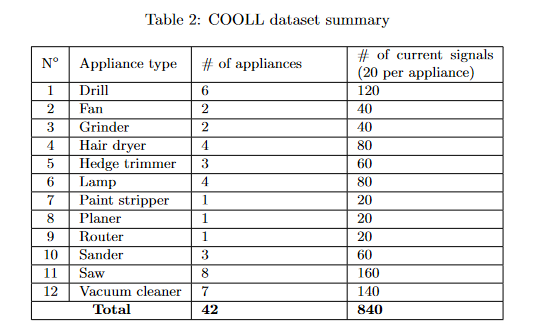
COOLL is a dataset of plug-level electrical measurements.  It contains turn-on current and voltagemeasurements  of  42  appliances  sampled  atFs=  100  kHz  (840  current  measurements  and  840voltage measurements)
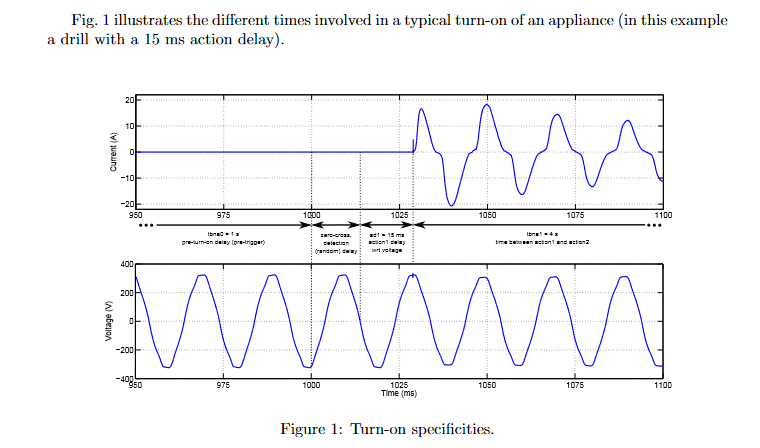
All the signals are taken from the COOLL dataset and converted into a numpy array in Python to be processed (see the file signal_extraction.py to understand how). COOLL dataset display 840 measurements of 42 appliances, where for each of them 20 measurements were performed. At the end of each algorithm, it could be useful to plot the respective feature : for good classification performaces a staircase-like graph is preferred.


In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import soundfile as sf #special library to read and manipulate audio files
from glob import glob
import os
app = ["Drill", "Fan", "Grinder", "Hair", "Hedge", "Lamp", "Sander", "Saw", "Vacuum"]

In [2]:
#%%
def loadfiles(current_audiofiles,voltage_audiofiles,c_scalef,v_scalef):
    
    current = []
    voltage = []
    	
    for i in np.arange(len(current_audiofiles)):
        audio, freq = sf.read(current_audiofiles[i])
        current.append([audio])

    for i in np.arange(len(voltage_audiofiles)):
        audio, freq = sf.read(voltage_audiofiles[i])
        voltage.append([audio])
    
    current = np.array(current)
    voltage = np.array(voltage)
    
    # de-normalization with scale factor
        
    for i in np.arange(len(current_audiofiles)):
        current[i,0] *= c_scalef[i]
        voltage[i,0] *= v_scalef[i]	
    
    time = (np.arange(0,len(audio))/freq)
    

    return current,voltage,time,freq


#%%
#this function is used to change the sort from 'ASCIIBetical' to numeric by isolating the number in the filename

def keyFunc(afilename):
    nondigits = re.compile("\D")
    return int(nondigits.sub("", afilename))


In [3]:
data_dir1 = "./dataset/COOLL_Data/current"
current_files = sorted(glob(data_dir1+'/*.flac'), key=keyFunc)

data_dir2 = "./dataset/COOLL_Data/voltage"
voltage_files = sorted(glob(data_dir2+'/*.flac'), key=keyFunc)

df = pd.read_excel("./dataset/scalefactors.xlsx")   # here scale factors where saved into a .xlsx file

#%%
c_scale = np.array(df.iloc[:,0],dtype='float32')      
v_scale = np.array(df.iloc[:,1],dtype='float32')

current, voltage, time, sampling_frequency = loadfiles(current_files,voltage_files,c_scale,v_scale)

(1, 599996)


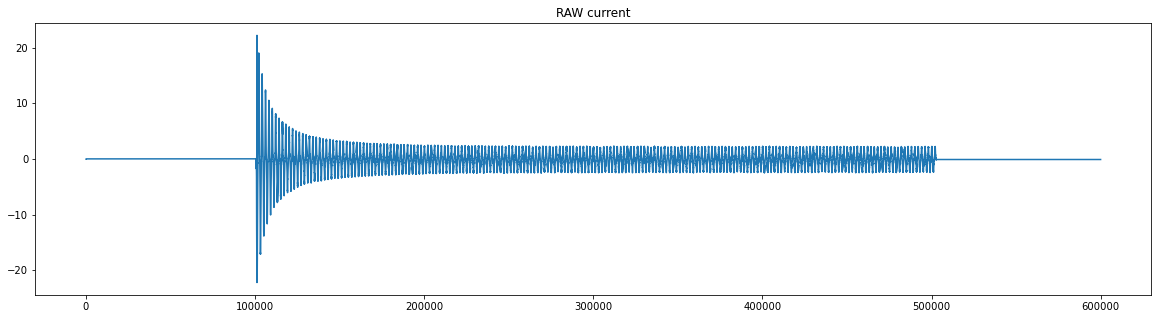

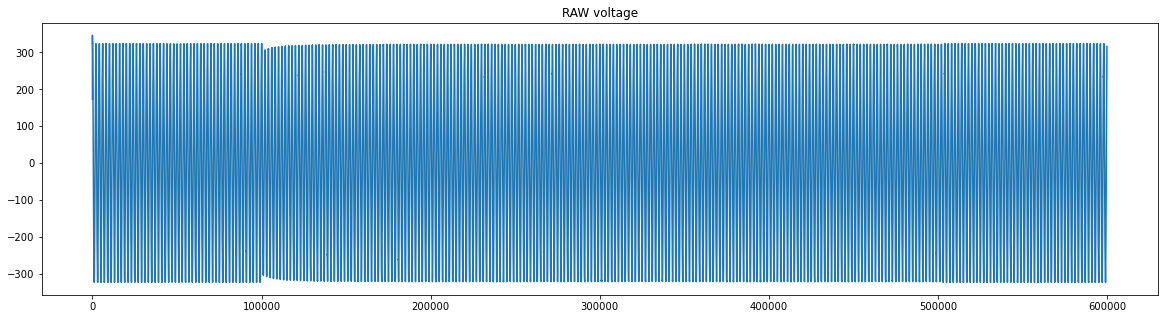

In [41]:
print (current[120].shape)
plt.figure(figsize=(20,5))
plt.title('RAW current')
plt.plot(current[1,0,:])
plt.figure(figsize=(20,5))
plt.title('RAW voltage')
plt.plot(voltage[1,0,:])


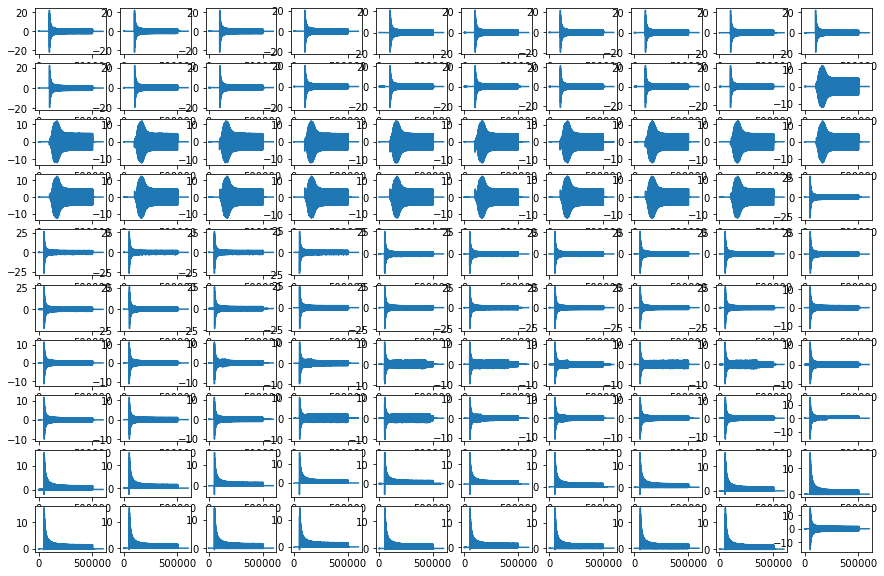

In [24]:
%matplotlib inline
# plt.figure(1)
plt.figure(figsize=(15,10))
plt.title('RAW signal')
# plt.plot(current[3,0])

for i in range(1,(len(current[10:111,0])),1):
    plt.subplot(10, 10, i)
    plt.plot(current[i,0])
plt.show() 
# plt.plot(x,y)

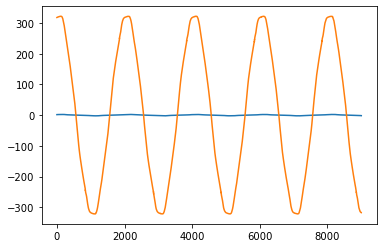

In [6]:
# steady state signal for appliance will process with moving average filter to found V-I trajectory
plt.plot(current[1,0,300000:309000])
plt.plot(voltage[1,0,300000:309000])

# plt.plot(current[1,0,200000:300000])
# plt.plot(voltage[1,0,200000:300000])


## Dataset Preprocessing

In [4]:
#label from meta file
def get_cool_data(path):
    
    labels   = {}
    delays   = {}
    Meta = {}
    meta_head= []
    meta_data= []
    with os.scandir(path) as entries:
        for entry in entries:
            if entry.is_dir():
                folder_name=entry.name
                with os.scandir(entry.path) as files:
                    for f in files:
                        if f.is_file():
                            f_id = f.name.strip().split("_")[-1].strip().split(".")[0]
                            #if f_id=="141":
                                #continue

                            if folder_name=="Configs":
                                meta_head= []
                                meta_data= []
                                with open(f.path, 'r') as l:
                                    line = l.readline()
                                    while line != '':  # The EOF char is an empty string
                                        if not line.lstrip().startswith('#'):
                                            meta=line.strip().split("=")

                                            meta_data.append(int(meta[-1]))
                                            meta_head.append(meta[0])
                                        line = l.readline()
                                    l.close()
                                    Meta[int(f_id)]=meta_data
                            if folder_name=="label":
                                with open(f.path, 'r') as l:
                                    line = l.readline()
                                    while line != '':  # The EOF char is an empty string
                                        app_id = line.strip().split("_")
                                        name=app_id[0].strip().split(":")
                                        labels[int(name[0])]=name[1].strip()
                                        delays[int(name[0])]=app_id[-1]
                                        #print(app_id[-1])
                                        line = l.readline()


    #print (meta_head) 
    return meta_head, Meta, labels

def moving_average(signal,window_size):
    numbers_series = pd.Series(signal)
    windows = numbers_series.rolling(window_size)
    moving_averages = windows.mean()

    moving_averages_list = moving_averages.tolist()
    without_nans = moving_averages_list[window_size - 1:]
    return without_nans

In [5]:
label_dir = "./dataset/"
meta_head, Meta, labels = get_cool_data(label_dir)

In [8]:
from scipy.signal import find_peaks

#%%
#STEP 1 & 2
#300000-309000 a steady state signal

current_cycle = []
voltage_cycle = []

for i in np.arange(len(current)):
   current_cycle.append(moving_average(current[i,0][300000:309000],140)) 
   voltage_cycle.append(moving_average(voltage[i,0][300000:309000],140))

   
current_cycle = np.array(current_cycle,dtype='float32')
voltage_cycle = np.array(voltage_cycle,dtype='float32')


In [9]:
c_cycle = []
v_cycle = []

for i in np.arange(len(current_cycle)):
  max_, _ = find_peaks(voltage_cycle[i],distance=1400)
#   c_cycle.append(np.hstack((current_cycle[i,max_[1]:max_[1]+2000],current_cycle[i,max_[-3]:max_[-3]+2000])))
#   v_cycle.append(np.hstack((voltage_cycle[i,max_[1]:max_[1]+2000],voltage_cycle[i,max_[-3]:max_[-3]+2000])))
  c_cycle.append(current_cycle[i,max_[1]:max_[1]+2020])#/ max(current_cycle[i,max_[1]:max_[1]+2020]))
  v_cycle.append(voltage_cycle[i,max_[1]:max_[1]+2020])#/ max(current_cycle[i,max_[1]:max_[1]+2020]))
                              
current_ss_cycle = np.array(c_cycle,dtype='float32')
voltage_ss_cycle = np.array(v_cycle,dtype='float32')


In [10]:
from scipy.signal import find_peaks

#%%
#STEP 1 & 2
#90000-99000 a off signal

current_cycle = []
voltage_cycle = []

for i in np.arange(len(current)):
   current_cycle.append(moving_average(current[i,0][100000:109000],140)) 
   voltage_cycle.append(moving_average(voltage[i,0][100000:109000],140))

   
current_cycle = np.array(current_cycle,dtype='float32')
voltage_cycle = np.array(voltage_cycle,dtype='float32')

In [11]:
cts_cycle = []
vts_cycle = []

for i in np.arange(len(current_cycle)):
  max_, _ = find_peaks(voltage_cycle[i],distance=1400)
#   c_cycle.append(np.hstack((current_cycle[i,max_[1]:max_[1]+2000],current_cycle[i,max_[-3]:max_[-3]+2000])))
#   v_cycle.append(np.hstack((voltage_cycle[i,max_[1]:max_[1]+2000],voltage_cycle[i,max_[-3]:max_[-3]+2000])))
  cts_cycle.append(current_cycle[i,max_[1]:max_[1]+2020])#/ max(current_cycle[i,max_[1]:max_[1]+2020]))
  vts_cycle.append(voltage_cycle[i,max_[1]:max_[1]+2020])#/ max(current_cycle[i,max_[1]:max_[1]+2020]))
                              
current_ts_cycle = np.array(cts_cycle,dtype='float32')
voltage_ts_cycle = np.array(vts_cycle,dtype='float32')


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
2020
<class 'list'>
5719


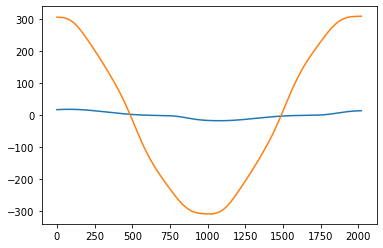

In [12]:
print (type(current))
print (type(current_ss_cycle))
plt.plot(current_ts_cycle[1])
plt.plot(voltage_ts_cycle[1])
# plt.plot(voltage_ss_cycle[1])
print (len(c_cycle[100]))
print (type(v_cycle))
print (max_[2])

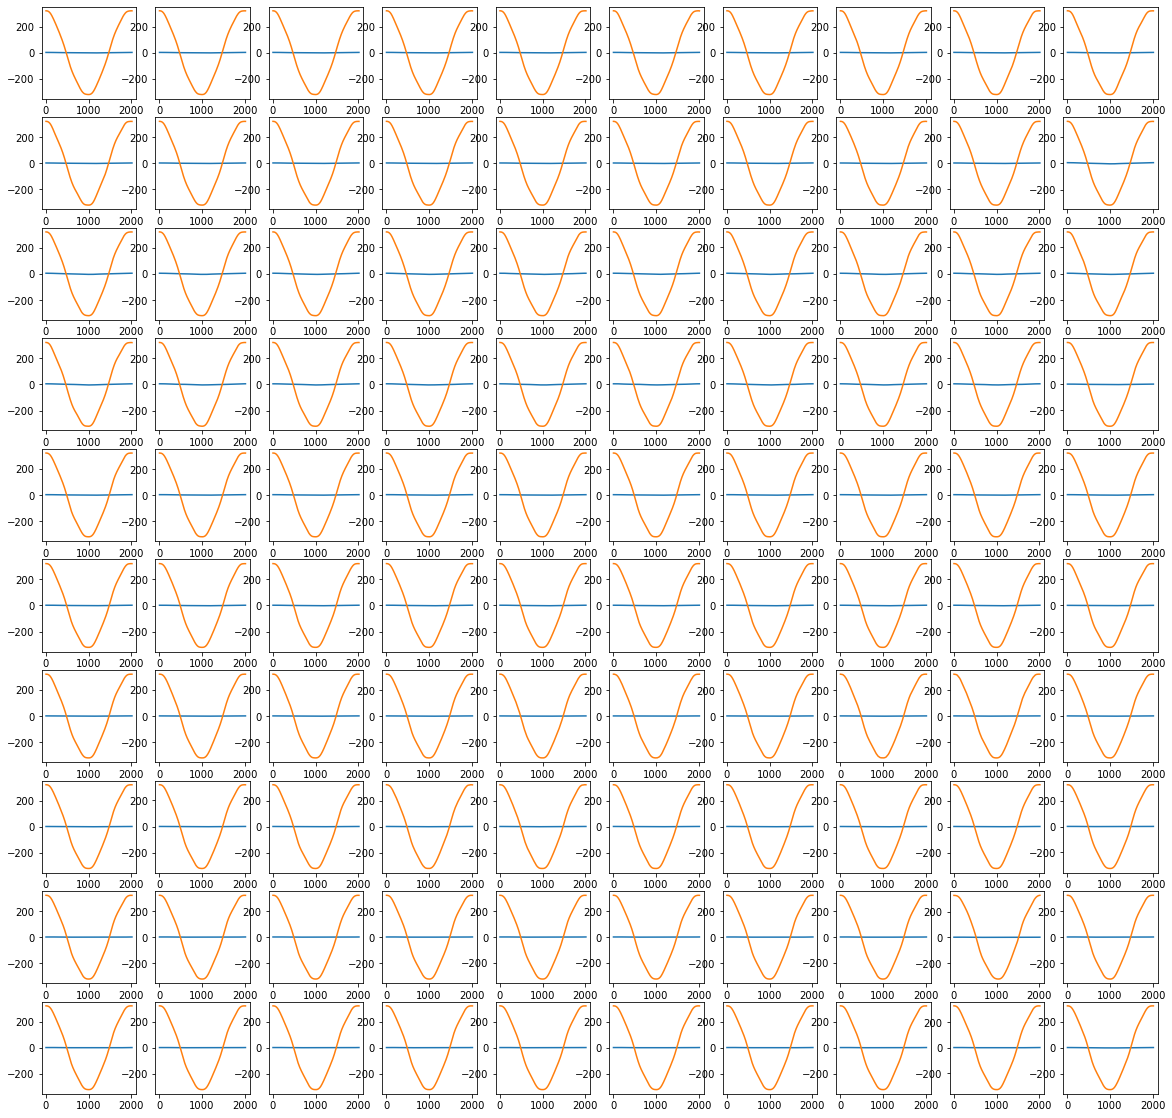

In [14]:
plt.figure(figsize=(20,20))
plt.title('Cycle for steady state')
for i in range(1,(len(current_ss_cycle[10:111])),1):
    plt.subplot(10, 10, i)
    plt.plot(current_ss_cycle[i])
    plt.plot(voltage_ss_cycle[i])
plt.show() 

In [13]:
from sklearn import preprocessing
def get_BinF(X,num):
    '''X should be nd array of size N*P, the output will be N*num'''
    (N,P) = X.shape
    newP = int(np.floor(P/num)*num)
    newX = np.reshape(X[:,:newP],[N,num,newP//num])
    BinF = np.sum(newX,2)
    return BinF
def normalize(v):
    norm = np.linalg.norm(v)+1e-16
    return v/norm
def stdmtx(v):
    means = v.mean(axis = 1)
    stds = v.std(axis-1, ddof =1)
    v = v - means[:,np.newaxis]
    v = v/ stds[:,np.newaxis]
    return np.nan_to_num(v)
#downsampling from 2000 to 64
BinF_I = get_BinF(current_ss_cycle,64)    
BinF_V = get_BinF(voltage_ss_cycle,64)
#normalize from V dan I
# BinF_I = normalize(BinF_I)
# BinF_V = normalize(BinF_V)
# BinF_I = preprocessing.normalize(BinF_I)
# BinF_V = preprocessing.normalize(BinF_V)

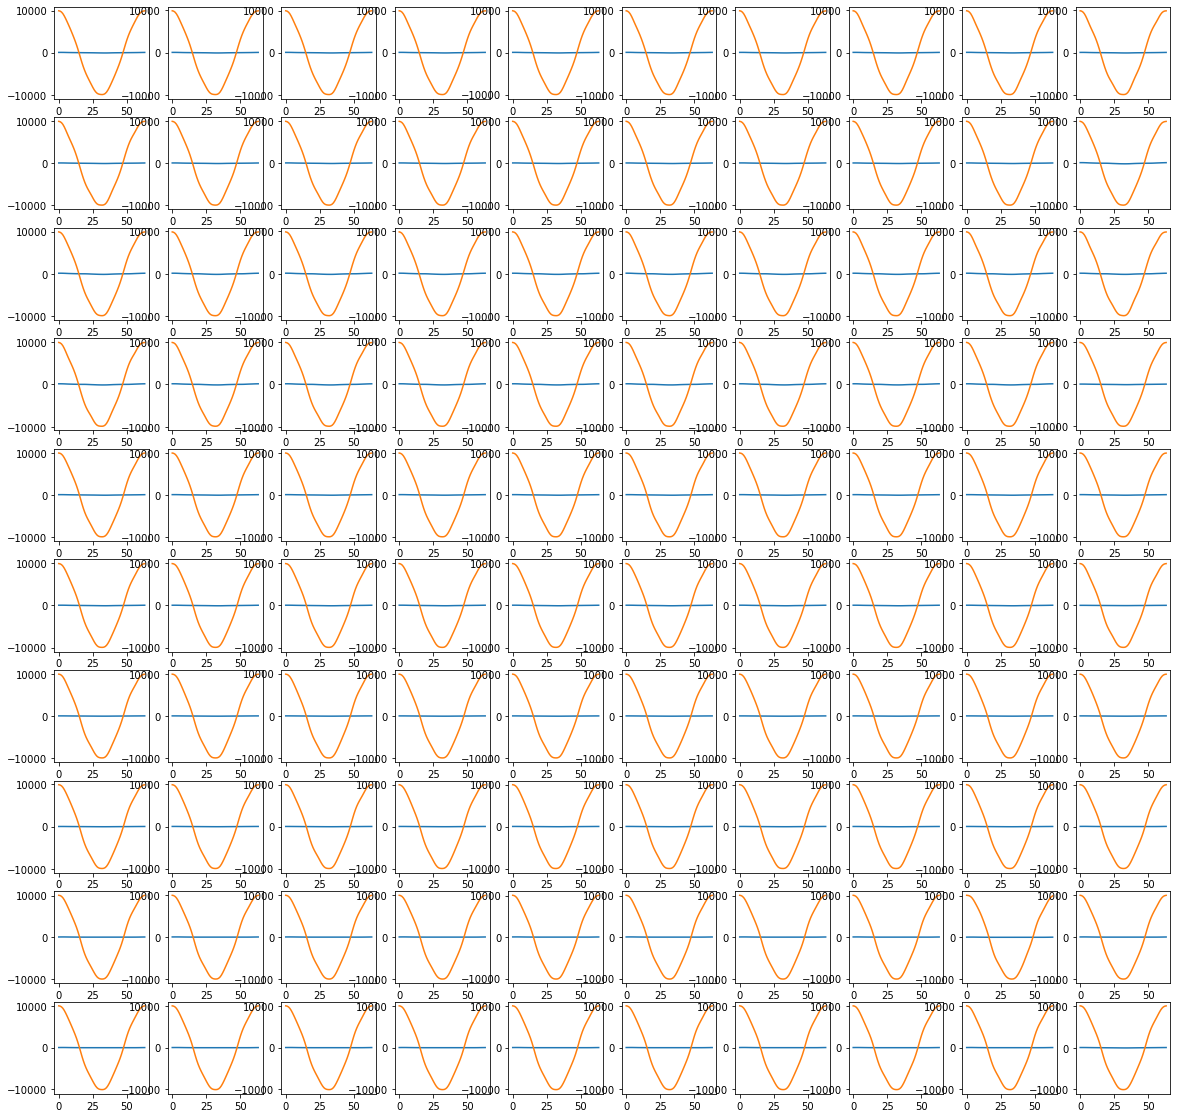

In [16]:
plt.figure(figsize=(20,20))
plt.title('Cycle for steady state Ts 64/signal')
for i in range(1,(len(BinF_I[10:111])),1):
    plt.subplot(10, 10, i)
    plt.plot(BinF_I[i])
    plt.plot(BinF_V[i])
plt.show() 

## Meta data 
meta_head = ['tbna0', 'act1', 'sofa1', 'ad1', 'tbna1', 'act2', 'sofa2', 'ad2', 'tbna2'] <br>

**Variables definition**<br>
act: actions (ON=1/OFF=0)<br>
sofa: selected outlet for each action<br>
ad: action delay wrt volt. Zero-Cross. (µs)<br>
tbna: time before next action (ms)<br>

840
840
840
[1000, 1, 1, 0, 4000, 0, 1, 0, 1000]
Drill
['Vacuum', 'Hedge', 'Planer', 'Paint', 'Lamp', 'Sander', 'Grinder', 'Router', 'Fan', 'Saw', 'Drill', 'Hair']


(array([120.,  40.,  40.,  80.,  60.,  80.,  20.,  20.,  20.,  60., 160.,
        140.]),
 array([ 0.        ,  0.91666667,  1.83333333,  2.75      ,  3.66666667,
         4.58333333,  5.5       ,  6.41666667,  7.33333333,  8.25      ,
         9.16666667, 10.08333333, 11.        ]),
 <BarContainer object of 12 artists>)

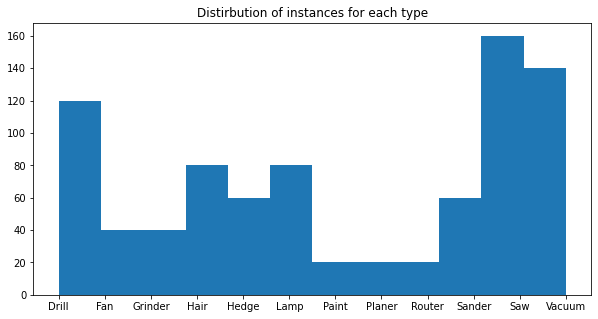

In [21]:
# print (size(Meta)
print (len(Meta)) # size of Meta
print (len(current_ss_cycle)) # size of dataset
print (len(labels)) #size of label
print (Meta[1])
print (labels[1])
#['tbna0', 'act1', 'sofa1', 'ad1', 'tbna1', 'act2', 'sofa2', 'ad2', 'tbna2']
# applinace types of all instances
# Types = [labels for x in labels]
# # unique appliance types
Unq_type = list(set(labels.values())) 
# Unq_type.sort()
print(Unq_type)
# print (labels.values())
plt.figure(figsize=(10,5))
plt.title('Distirbution of instances for each type')
plt.hist(labels.values(),len(Unq_type))
# print (Unq_type)

In [22]:
#label encoding
#print (Unq_type[1])
labels_id = []
for i in range(1,len(labels.values())+1,1):
    for j in range(len(Unq_type)):
        if (labels[i] == Unq_type[j]):
            labels_id.append(j)
# for i in range(1,839,1):
#     print (labels_id[i])
#     print (labels[i])
#print (len(labels_id))

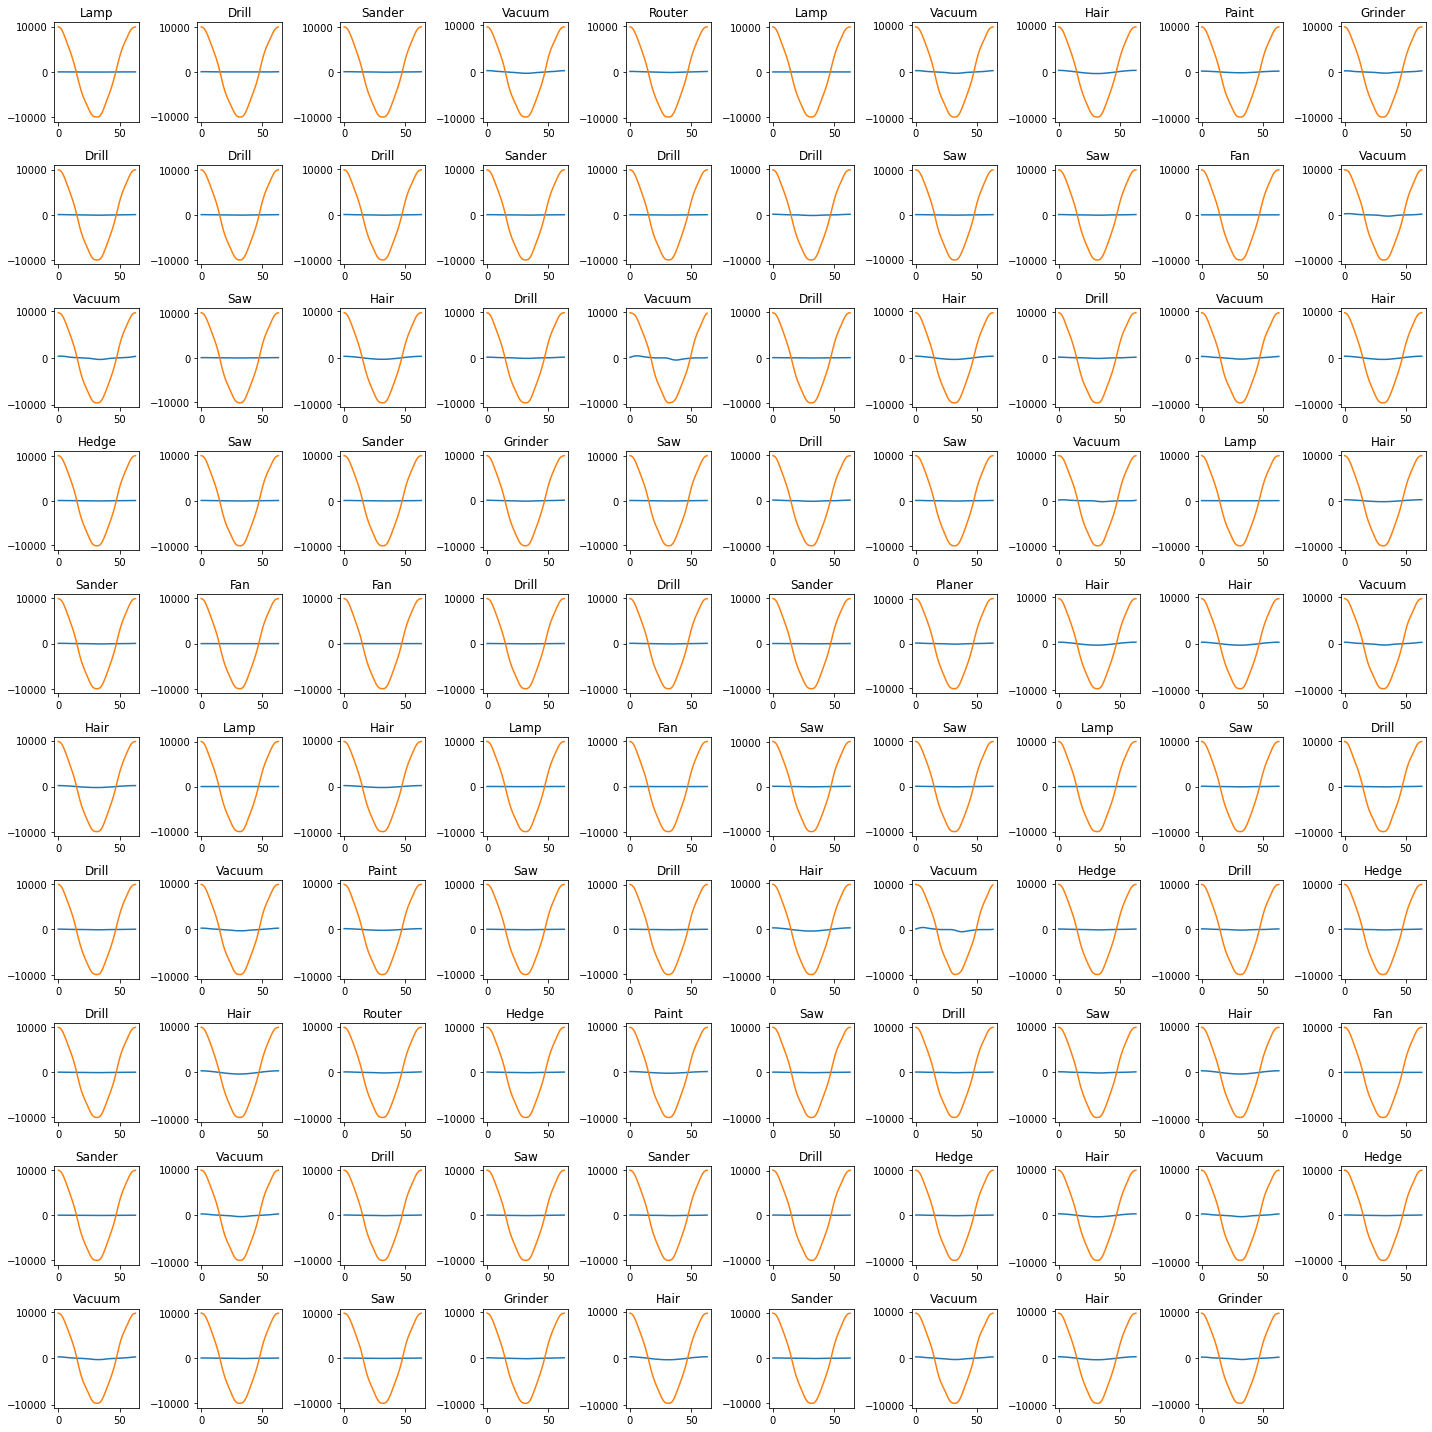

In [23]:
#with labels
import random
plt.figure(figsize=(20,20))
plt.title('Cycle for steady state Ts 64/signal with label')
for i in range(1,(len(BinF_I[0:100])),1):
    ax = plt.subplot(10, 10, i)
#     print (labels_test[i])
    n = random. randint(1,839) 
    ax.set_title(str(labels[n]))
    plt.plot(BinF_I[n])
    plt.plot(BinF_V[n])
#     set_title(f'test')
plt.tight_layout()
plt.show() 
#orange voltage and blue current

## Dataset Preprocessing V-I trajectory
This feature come from : 
A. L. Wang, B. X. Chen, C. G. Wang, and D. D. Hua, "Non-intrusive load monitoring algorithm based on features of V–I trajectory" Electric Power Systems Research, 2018. <br/>
https://github.com/giobraglia/Signal-Processing-Features
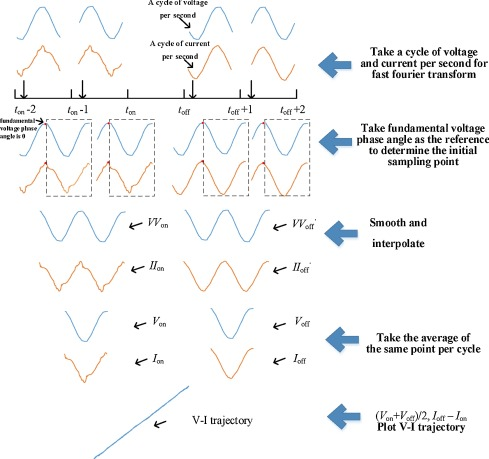

In [14]:
current_ = current_ss_cycle
voltage_ = voltage_ss_cycle

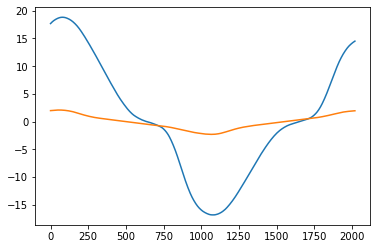

In [15]:
plt.plot (current_ts_cycle[1])
plt.plot (current_ss_cycle[1])

[321.26978 321.2693  321.2674  ... 320.97064 320.93448 320.8959 ]
[0.21371643 0.21386494 0.21401116 ... 0.21673496 0.21688892 0.21704   ]


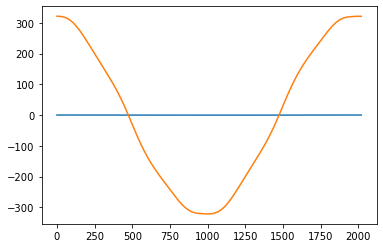

In [16]:
# plt.plot(voltage_[120])
print (voltage_[120])
print (current_[120])
plt.plot (current_[120])
plt.plot (voltage_[120])


In [18]:
def center(X,w):
    minX = np.amin(X)
    maxX = np.amax(X)
    dist = max(abs(minX),maxX)
    X[X<-dist] = -dist
    X[X>dist] = dist
    d = (maxX-minX)/w
    return (X,d)
def get_img_from_VI(V, I, width,hard_threshold=False,para=.5):
    '''Get images from VI, hard_threshold, set para as threshold to cut off,5-10
    soft_threshold, set para to .1-.5 to shrink the intensity'''
    d = V.shape[0]
    # doing interploation if number of points is less than width*2
    if d<2* width:
        newI = np.hstack([V, V[0]])
        newV = np.hstack([I, I[0]])
        oldt = np.linspace(0,d,d+1)
        newt = np.linspace(0,d,2*width)
        I = np.interp(newt,oldt,newI)
        V = np.interp(newt,oldt,newV)
    # center the current and voltage, get the size resolution of mesh given width    
    (I,d_c)  = center(I,width)
    (V,d_v)  = center(V,width)
    

    #  find the index where the VI goes through in current-voltage axis
    ind_c = np.floor((I-np.amin(I))/d_c).astype(int)
    ind_v = np.floor((V-np.amin(V))/d_v).astype(int)
    ind_c[ind_c==width] = width-1
    ind_v[ind_v==width] = width-1
    
    Img = np.zeros((width,width))
    
    for i in range(len(I)):
        Img[ind_c[i],width-ind_v[i]-1] += 1
    return  (Img/np.max(Img))**para

In [157]:
# VI_img = []
width = 8
Imgs = np.zeros((len(BinF_V4),width,width), dtype=np.float64)
for i in range(len(BinF_V4)):
    Imgs[i,:,:] = get_img_from_VI(BinF_V4[i], BinF_I4[i], width, False,0.5)
#     Imgs[i,:,:] = get_img_from_VI(voltage_[i], current_[i], width, False, 0.5)
# BinaryF=np.reshape(Imgs,((len(BinF_V)),width*width))
# current_ss_cycle

Drill 8


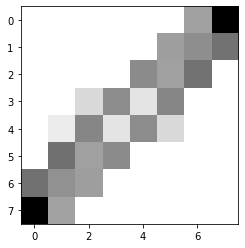

In [158]:
plt.imshow(Imgs[120],cmap='gray_r',interpolation = None)
print (str(labels[labels_id[120]]),labels_id[120])

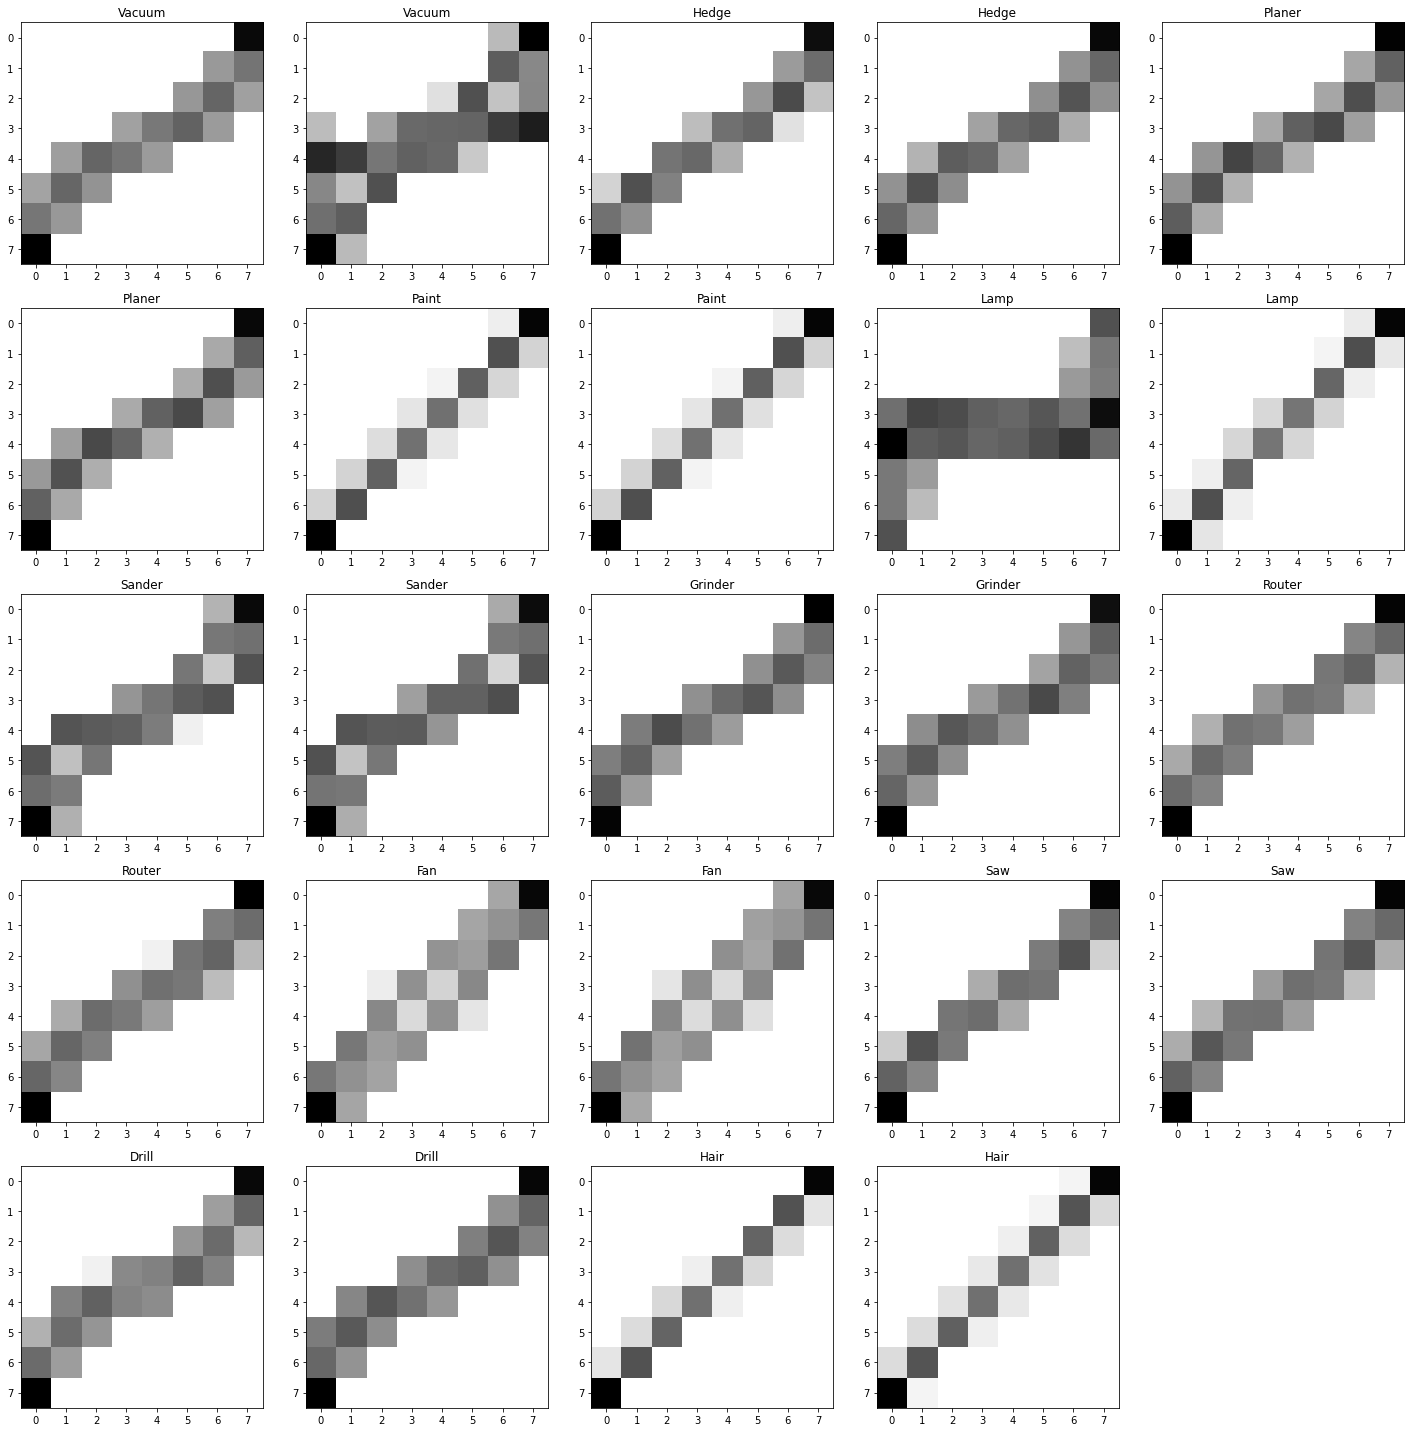

In [136]:
plt.figure(figsize=(20,20))
plt.title('Cycle for steady state Ts 64/signal with label')
for i in range(1,25,1):
    ax = plt.subplot(5, 5, i)
#     print (labels_test[i])
    idx = np.random.choice(np.where(np.array(labels_id)==(i-1)//2)[0])
#     n = random. randint(1,839) 
    ax.set_title(str(labels[idx]))
    plt.imshow(Imgs[idx],cmap='gray_r',interpolation = None)
#     set_title(f'test')
plt.tight_layout()
plt.show() 


In [ ]:
# print (np.where(np.array(labels_id)==11))
idx = np.random.choice(np.where(np.array(labels_id)==%11)[0])
print (idx)

## Embedding dataset

In [153]:
from sklearn.utils import shuffle

np.random.seed(6)
x_values, y_values = Imgs, labels_id
# x_values /= x_values.max()
#reshape for input tensorflow
x_values = x_values.reshape((len(x_values), 8, 8, 1))
#shuffle random dataset
x_values, y_values = shuffle(x_values, y_values)
# split into train, validation, test
TRAIN_SPLIT = int(0.6 * len(x_values))
TEST_SPLIT = int(0.2 * len(x_values) + TRAIN_SPLIT)
x_train, x_test, x_validate = np.split(x_values, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_test, y_validate = np.split(y_values, [TRAIN_SPLIT, TEST_SPLIT])

#    x_train, x_test, x_validate, y_train, y_test, y_validate

In [124]:
len(x_train)

504

# IT'S Training TIME

In [154]:
import math
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tinymlgen import port

In [155]:
model = tf.keras.Sequential()
model.add(layers.Conv2D(16, (2, 2), activation='relu', input_shape=(8, 8, 1)))
# model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (2, 2), activation='relu'))
# model.add(layers.MaxPooling2D((1, 1)))
# model.add(layers.Conv2D(32, (1, 1), activation='relu'))
# model.add(layers.Conv2D(32, (1, 1), activation='relu'))
model.add(layers.Flatten())
# model.add(layers.Dense(64, activation='softmax'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.4))
# model.add(layers.Dense(128, activation='relu'))
# model.add(layers.Dropout(0.5))
model.add(layers.Dense(12, activation='softmax'))
# model.add(layers.Dense(12))
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=200, batch_size=16,validation_data=(x_validate, y_validate))
#     return model, x_test,y_test

Epoch 1/200
32/32 [==============================] - 1s 8ms/step - loss: 2.3958 - accuracy: 0.1839 - val_loss: 2.1050 - val_accuracy: 0.3631
Epoch 2/200
32/32 [==============================] - 0s 4ms/step - loss: 2.1075 - accuracy: 0.3052 - val_loss: 1.8209 - val_accuracy: 0.4643
Epoch 3/200
32/32 [==============================] - 0s 4ms/step - loss: 1.7872 - accuracy: 0.4351 - val_loss: 1.6690 - val_accuracy: 0.4881
Epoch 4/200
32/32 [==============================] - 0s 3ms/step - loss: 1.6834 - accuracy: 0.4295 - val_loss: 1.3677 - val_accuracy: 0.5298
Epoch 5/200
32/32 [==============================] - 0s 4ms/step - loss: 1.3663 - accuracy: 0.5387 - val_loss: 1.2511 - val_accuracy: 0.5536
Epoch 6/200
32/32 [==============================] - 0s 3ms/step - loss: 1.3669 - accuracy: 0.5155 - val_loss: 1.1273 - val_accuracy: 0.5893
Epoch 7/200
32/32 [==============================] - 0s 3ms/step - loss: 1.2506 - accuracy: 0.5293 - val_loss: 1.0890 - val_accuracy: 0.5893
Epoch 8/200
3

Epoch 59/200
32/32 [==============================] - 0s 3ms/step - loss: 0.3469 - accuracy: 0.8690 - val_loss: 0.2195 - val_accuracy: 0.9167
Epoch 60/200
32/32 [==============================] - 0s 3ms/step - loss: 0.3269 - accuracy: 0.8822 - val_loss: 0.1822 - val_accuracy: 0.9643
Epoch 61/200
32/32 [==============================] - 0s 3ms/step - loss: 0.2566 - accuracy: 0.9206 - val_loss: 0.1631 - val_accuracy: 0.9762
Epoch 62/200
32/32 [==============================] - 0s 3ms/step - loss: 0.2961 - accuracy: 0.8824 - val_loss: 0.1753 - val_accuracy: 0.9940
Epoch 63/200
32/32 [==============================] - 0s 3ms/step - loss: 0.3151 - accuracy: 0.8601 - val_loss: 0.1787 - val_accuracy: 0.9583
Epoch 64/200
32/32 [==============================] - 0s 3ms/step - loss: 0.2937 - accuracy: 0.8929 - val_loss: 0.1495 - val_accuracy: 0.9940
Epoch 65/200
32/32 [==============================] - 0s 3ms/step - loss: 0.3287 - accuracy: 0.8766 - val_loss: 0.1786 - val_accuracy: 0.9702
Epoch 

32/32 [==============================] - 0s 3ms/step - loss: 0.1189 - accuracy: 0.9675 - val_loss: 0.0723 - val_accuracy: 0.9881
Epoch 117/200
32/32 [==============================] - 0s 4ms/step - loss: 0.1799 - accuracy: 0.9233 - val_loss: 0.0965 - val_accuracy: 0.9762
Epoch 118/200
32/32 [==============================] - 0s 4ms/step - loss: 0.1752 - accuracy: 0.9379 - val_loss: 0.0616 - val_accuracy: 0.9940
Epoch 119/200
32/32 [==============================] - 0s 3ms/step - loss: 0.1249 - accuracy: 0.9531 - val_loss: 0.0552 - val_accuracy: 0.9940
Epoch 120/200
32/32 [==============================] - 0s 3ms/step - loss: 0.1496 - accuracy: 0.9449 - val_loss: 0.0551 - val_accuracy: 0.9940
Epoch 121/200
32/32 [==============================] - 0s 3ms/step - loss: 0.1451 - accuracy: 0.9663 - val_loss: 0.0459 - val_accuracy: 0.9940
Epoch 122/200
32/32 [==============================] - 0s 3ms/step - loss: 0.1651 - accuracy: 0.9421 - val_loss: 0.0518 - val_accuracy: 0.9940
Epoch 123/200

32/32 [==============================] - 0s 3ms/step - loss: 0.0987 - accuracy: 0.9634 - val_loss: 0.0692 - val_accuracy: 0.9702
Epoch 174/200
32/32 [==============================] - 0s 3ms/step - loss: 0.1301 - accuracy: 0.9502 - val_loss: 0.0630 - val_accuracy: 0.9762
Epoch 175/200
32/32 [==============================] - 0s 4ms/step - loss: 0.1187 - accuracy: 0.9556 - val_loss: 0.0548 - val_accuracy: 0.9881
Epoch 176/200
32/32 [==============================] - 0s 4ms/step - loss: 0.0928 - accuracy: 0.9634 - val_loss: 0.0385 - val_accuracy: 0.9881
Epoch 177/200
32/32 [==============================] - 0s 4ms/step - loss: 0.1184 - accuracy: 0.9631 - val_loss: 0.0318 - val_accuracy: 0.9940
Epoch 178/200
32/32 [==============================] - 0s 3ms/step - loss: 0.0972 - accuracy: 0.9726 - val_loss: 0.0240 - val_accuracy: 0.9940
Epoch 179/200
32/32 [==============================] - 0s 4ms/step - loss: 0.1356 - accuracy: 0.9346 - val_loss: 0.0402 - val_accuracy: 0.9881
Epoch 180/200

ACCURACY ON TEST 0.9940476190476191
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


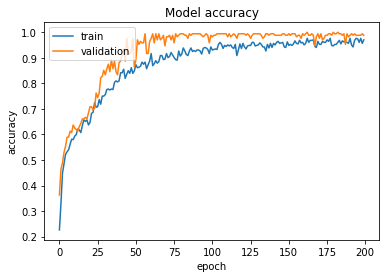

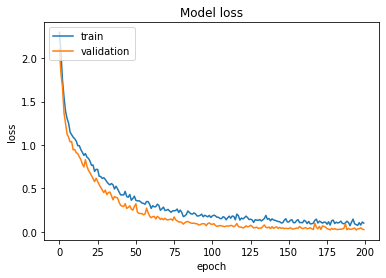

In [159]:
x_test = (x_test / x_test.max()).reshape((len(x_test), 8, 8, 1))
y_pred = model.predict(x_test).argmax(axis=1)
print('ACCURACY ON TEST', (y_pred == y_test).sum() / len(y_test))
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [128]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 7, 7, 16)          80        
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 6, 6, 32)          2080      
_________________________________________________________________
flatten_12 (Flatten)         (None, 1152)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 64)                73792     
_________________________________________________________________
dropout_12 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 12)                780       
Total params: 76,732
Trainable params: 76,732
Non-trainable params: 0
_________________________________________________

In [129]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True,show_layer_names=False, to_file='model.png')


('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


Text(0.5, 15.0, 'Predicted')

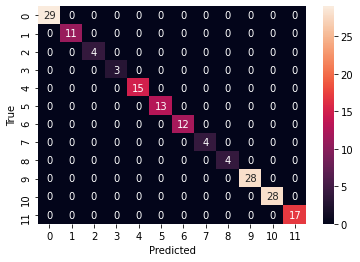

In [141]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(x_test).argmax(axis=1)
confusion_mtx = confusion_matrix(y_test, y_pred) 
sns.heatmap(confusion_mtx, annot=True, fmt="d")
plt.ylabel('True')
plt.xlabel('Predicted')

In [131]:
for (i, it) in enumerate(Unq_type,0):
    print(i, it)


0 Vacuum
1 Hedge
2 Planer
3 Paint
4 Lamp
5 Sander
6 Grinder
7 Router
8 Fan
9 Saw
10 Drill
11 Hair


## Test different size of sampling

In [85]:
#downsampling from 2000 to 64
BinF_I1 = get_BinF(current_ss_cycle,10)    
BinF_V1 = get_BinF(voltage_ss_cycle,10)
BinF_I2 = get_BinF(current_ss_cycle,150)    
BinF_V2 = get_BinF(voltage_ss_cycle,150)
BinF_I3 = get_BinF(current_ss_cycle,200)    
BinF_V3 = get_BinF(voltage_ss_cycle,200)
BinF_I4 = get_BinF(current_ss_cycle,144)    
BinF_V4 = get_BinF(voltage_ss_cycle,144)
#normalize from V dan I

## Convert to TFlite

In [36]:
#with the power of tinymlgen
c_code = port(model, optimize=False, variable_name='PlugID_model', pretty_print=True)
print(c_code)

INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmp4seiuuu6\assets

#ifdef __has_attribute
#define HAVE_ATTRIBUTE(x) __has_attribute(x)
#else
#define HAVE_ATTRIBUTE(x) 0
#endif
#if HAVE_ATTRIBUTE(aligned) || (defined(__GNUC__) && !defined(__clang__))
#define DATA_ALIGN_ATTRIBUTE __attribute__((aligned(4)))
#else
#define DATA_ALIGN_ATTRIBUTE
#endif

const unsigned char PlugID_model[] DATA_ALIGN_ATTRIBUTE = {
	0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x14, 0x00, 0x20, 0x00, 
	0x04, 0x00, 0x08, 0x00, 0x0c, 0x00, 0x10, 0x00, 0x14, 0x00, 0x00, 0x00, 
	0x18, 0x00, 0x1c, 0x00, 0x14, 0x00, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00, 
	0x18, 0x00, 0x00, 0x00, 0x28, 0x00, 0x00, 0x00, 0xcc, 0x00, 0x00, 0x00, 
	0x28, 0x00, 0x00, 0x00, 0x74, 0x00, 0x00, 0x00, 0x6c, 0x00, 0x00, 0x00, 
	0x04, 0x00, 0x00, 0x00, 0x88, 0x05, 0x00, 0x00, 0xb4, 0x03, 0x00, 0x00, 
	0xf0, 0x02, 0x00, 0x00, 0x94, 0x01, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00, 
	0xc8, 0x00, 0x00, 0x00, 0x12, 0x00, 0x00, 0x00, 0x

In [37]:
print (y_test[1], y_pred[1])
print (x_test[1])

11 11
[[[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.34921515]
  [0.97530483]]

 [[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.36066785]
  [0.42292055]
  [0.52575923]]

 [[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.42611244]
  [0.36440544]
  [0.5359691 ]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.09016696]
  [0.43864784]
  [0.1646216 ]
  [0.4656202 ]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.46852129]
  [0.15617376]
  [0.43554781]
  [0.11640505]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.53343495]
  [0.38254603]
  [0.43242557]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.53088871]
  [0.42928061]
  [0.34921515]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]]

 [[1.        ]
  [0.34136661]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]]]


### test on disco_f407vg > cppcheck (platform: ststm32; board: disco_f407vg; framework: arduino)
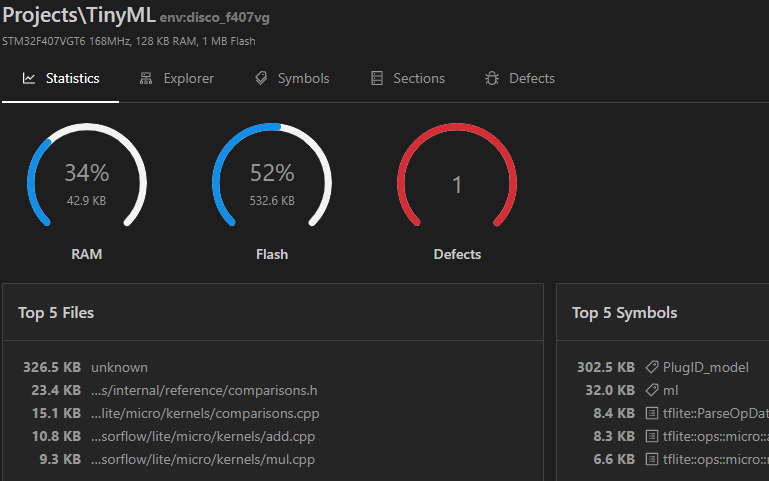
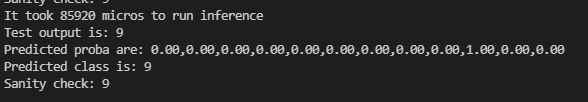

In [38]:
model.save("./")


INFO:tensorflow:Assets written to: ./assets


INFO:tensorflow:Assets written to: ./assets


In [39]:
model.save("./model.h5")

In [40]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")

In [ ]:
#test different type of sampling
